# Lab 2: Exploring Image Data
## by Michael Doherty, Leilani Guzman, and Carson Pittman

## 1. Business Understanding
Self-driving cars. Utter these words and most people will think of a futuristic, technologically advanced society. Yet, believe it or not, the concept of fully autonomous vehicles dates all the way back to the 16th century, when Leonardo da Vinci created a cart that was capable of moving on its own. While it took several centuries before any more progress on autonomous cars was made, since the early 1900s, several advancements have been made in the field. The most notable recent example is Tesla, who has a "Full Self-Driving package" that allows for "hands-free control for highway and freeway driving." Despite this, fully autonomous commercial vehicles have yet to be developed. ([Source](https://www.tomorrowsworldtoday.com/2021/08/09/history-of-autonomous-cars/))

One of the major issues that self-driving cars face is the concept of computer vision. Computer vision is the process by which computers use visual input (such as pictures and videos) to determine what action they should take. For a car to be fully autonomous, it needs to be able to recognize and react to a multitude of scenarios that could occur while driving (in a similiar fashion to how a human driver would react). Thus, self-driving cars need to be able to identify other vehicles and differentiate them from other entities, such as the road and sky.

The dataset we've selected, titled "Vehicle Detection Image Set", was created with this goal in mind. The dataset contains two directories, "vehicles" and "non-vehicles", which can be used to train machine learning models to differentiate between what images contain vehicles and which do not. Each image in the dataset is 64x64 pixels, with pictures in the "vehicles" folder containing images of various cars and pictures in the "non-vehicles" folder containing images of trees, the sky, the road, road signs, and other things a car would "see" while driving.

Thus, the prediction task for this dataset is to determine if any given image contains a vehicle. This is an extremely important concept for a self-driving car to be able to do, so any vehicle company that is working on self-driving cars (both partially and fully autonomous), such as Tesla, would be interested in the results of training machine learning models on this dataset. Hence, the importance of this dataset is clear: it can be used to research new methods for computer vision and improve existing models, all in the hopes of eventually creating a fully self-driving car.

So what does a good prediction algorithm for this dataset look like? There are several factors that need to be considered:
- **Accuracy**: How accurate the prediction algorithm is at classifying vehicles and non-vehicles is one of the most important aspects. As car crashes can be fatal, the prediction algorithm needs to have close to 100% accuracy; at the very least, it needs to be better than humans at identifying what is a vehicle and what is not. 
- **False Positives vs. False Negatives**: The number of false positives (identifying a vehicle when none is present) and false negatives (not identifying a vehicle when one is present) need to be minimized, as both could lead to undesirable situations while driving. However, minimizing the number of false negatives should take priority; while identifying a vehicle when none are present could lead to dangerous situations, failing to identify when a vehicle is present would almost always lead to (potentially fatal) car crashes.
- **Prediction Time**: How long it takes the model to make a prediction for a given image is also extremely important. While driving, an autonomous car is receiving live image data of what is in front of it. If the algorithm takes 5 seconds to make a prediction, it wouldn't be very useful (as it wouldn't be able to make decisions in a safe and reasonable amount of time). Since the average reaction time for humans while driving is 0.75 seconds ([Source](https://www.jdpower.com/cars/shopping-guides/when-driving-what-is-the-average-reaction-time#:~:text=The%20average%20reaction%20time%20when,response%20to%20a%20road%20situation.)), the prediction model should at a minimum be able to match this threshold (and ideally, it should be faster than this).

Ultimately, any machine learning model trained on this data needs to be better than humans to justify its inclusion in an autonomous vehicle. A model that is more accurate, less error prone, and faster at detecting vehicles in an image is a must for any fully autonomous, self-driving car.

Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 2. Data Preparation

In [2]:
import numpy as np
import PIL
import PIL.Image
import glob
import matplotlib.pyplot as plt

#load in images and labels as numpy arrays
images_and_labels = []
# labels = []
for filename in glob.glob('data/vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'vehicle')))


for filename in glob.glob('data/non-vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'non_vehicle')))
 

print(images_and_labels[0][0].shape[0])      # linearized 64x64 image -> 4096
print('There are', len(images_and_labels), 'images/rows')

4096
There are 17760 images/rows


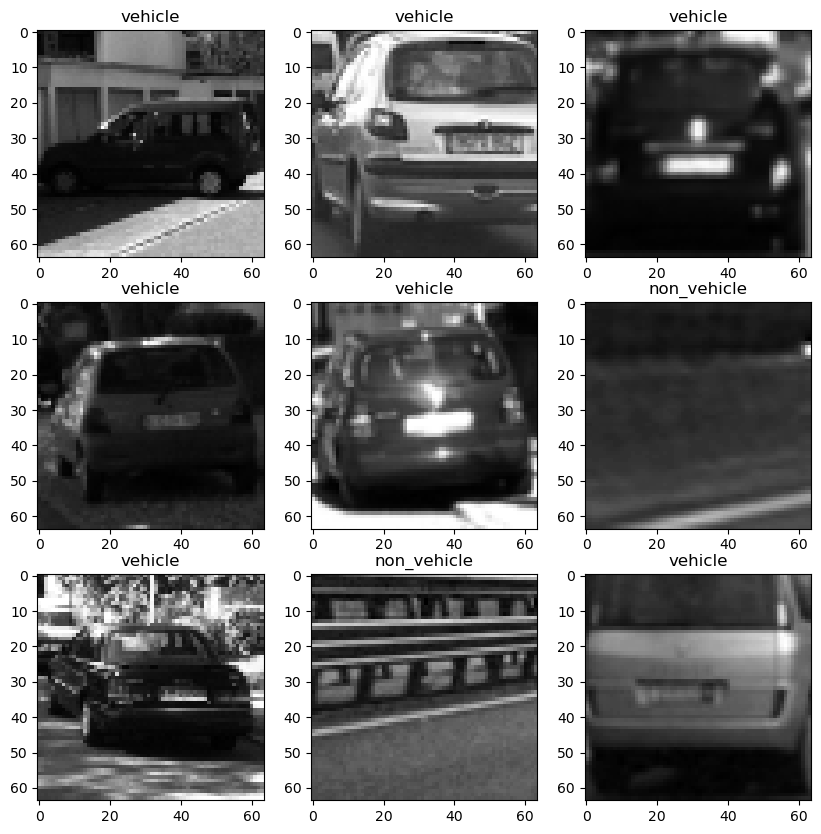

In [3]:
plt.figure(figsize=(10,10))
#plot some images
for i in range(9):
    plt.subplot(3,3, i+1)
    index = np.random.randint(0, len(images_and_labels))
    plt.imshow(images_and_labels[index][0].reshape(64,64), cmap='gray') # remove cmap if needed
    plt.title(images_and_labels[index][1])

## 3. Data Reduction

In [ ]:
from sklearn.decomposition import PCA

n_components = 300

pca = PCA(n_components=n_components)
# pca.fit(images_and_labels)    # this section still needs work
# altered_images = pca.components_.reshape((n_components, 64, 64))

## 4. Feature Extraction Using DAISY Key Point Matching

DAISY Descriptors (P,Q,R):  (2, 2, 78)


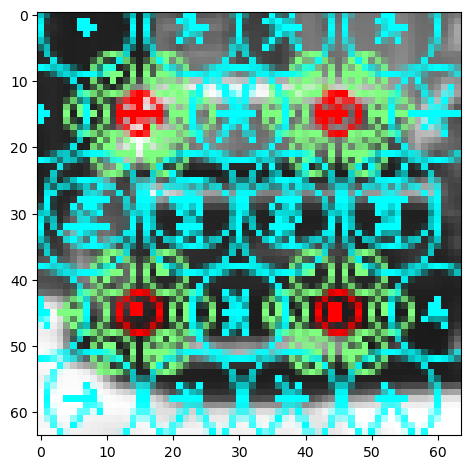

In [28]:
from skimage.io import imshow
from skimage.feature import daisy


#Example on one image
features, image_description = daisy(images_and_labels[0][0].reshape((64,64)), step=30, radius=15, rings=2, histograms=6, orientations=6, visualize=True)

imshow(image_description)

print('DAISY Descriptors (P,Q,R): ', features.shape)


In [38]:

def use_daisy(img, dim):
    features = daisy(img.reshape((dim,dim)), step=30, radius=15, rings=2, histograms=6, orientations=6)
    new_shape = features.shape
    return features.reshape((new_shape[0]*new_shape[1], new_shape[2],))

d_images_and_labels = []
for i in range(len(images_and_labels)):
    d_images_and_labels.append(tuple((use_daisy(images_and_labels[i][0], 64), images_and_labels[i][1])))



In [67]:
from skimage.feature import match_descriptors

#finding key points, TESTING PHASE

matches_found = []

#needs to run for all images, trying to see if this method works first
for index in range(50):
    best_percentage = 0
    best_match = []
    best_match_class = ''
    best_index = -1
    for other_index in range(50):
        if index != other_index:
            matches = match_descriptors(d_images_and_labels[index][0], d_images_and_labels[other_index][0], cross_check=True)
            percentage = 100*matches.shape[0]/len(d_images_and_labels[index][0])
            if percentage > best_percentage:
                print('Better match found between', index, 'and', other_index, 'with', matches.shape[0], 'matches')
                print('Matched descriptors: ', matches)
                print('Labels: ', d_images_and_labels[index][1], 'and', d_images_and_labels[other_index][1])
                print('Percentage:', 100*matches.shape[0]/len(d_images_and_labels[index][0]))
                print('')
                best_percentage = percentage
                best_match = matches
                best_match_class = d_images_and_labels[other_index][1]
                best_index = other_index
    matches_found.append(tuple((best_match, best_percentage, best_match_class, best_index)))

Better match found between 0 and 1 with 2 matches
Matched descriptors:  [[1 1]
 [3 3]]
Labels:  vehicle and vehicle
Percentage: 50.0

Better match found between 0 and 4 with 3 matches
Matched descriptors:  [[1 0]
 [2 2]
 [3 1]]
Labels:  vehicle and vehicle
Percentage: 75.0

Better match found between 0 and 6 with 4 matches
Matched descriptors:  [[0 0]
 [1 1]
 [2 2]
 [3 3]]
Labels:  vehicle and vehicle
Percentage: 100.0

Better match found between 1 and 0 with 2 matches
Matched descriptors:  [[1 1]
 [3 3]]
Labels:  vehicle and vehicle
Percentage: 50.0

Better match found between 1 and 2 with 3 matches
Matched descriptors:  [[0 0]
 [1 3]
 [3 1]]
Labels:  vehicle and vehicle
Percentage: 75.0

Better match found between 1 and 20 with 4 matches
Matched descriptors:  [[0 0]
 [1 1]
 [2 2]
 [3 3]]
Labels:  vehicle and vehicle
Percentage: 100.0

Better match found between 2 and 0 with 2 matches
Matched descriptors:  [[2 2]
 [3 1]]
Labels:  vehicle and vehicle
Percentage: 50.0

Better match foun

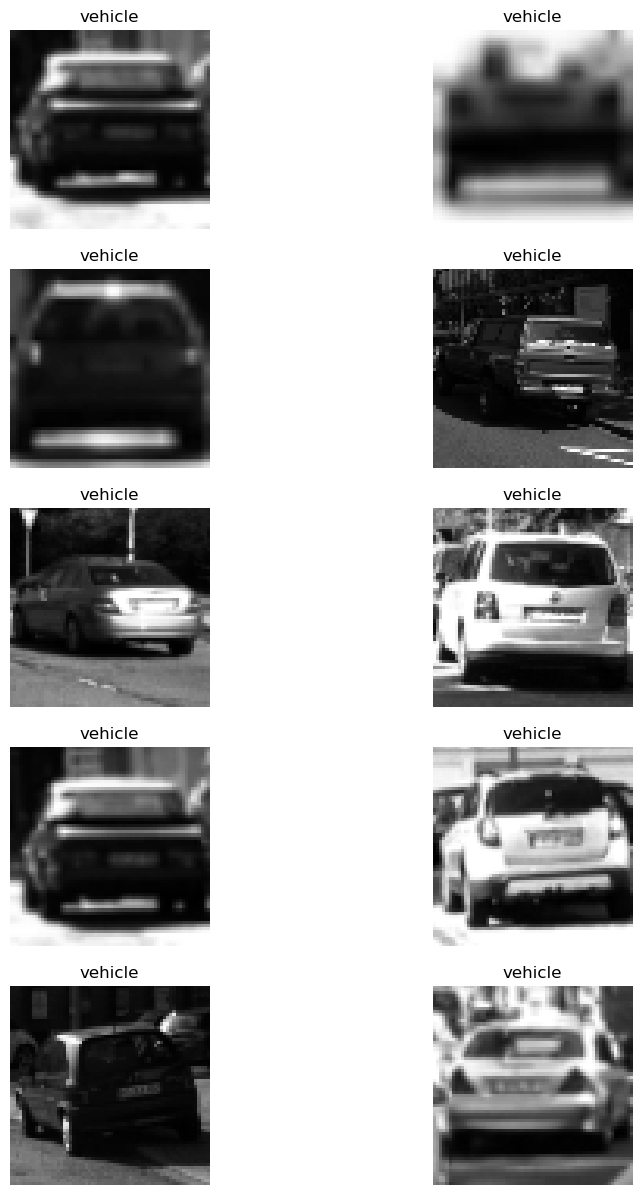

In [68]:
#print the original images and their best matches
plt.figure(figsize=(10,15))
for i in range(10):
    plt.subplot(5,2, i+1)
    plt.imshow(images_and_labels[i][0].reshape(64,64), cmap='gray') 
    plt.axis('off')
    plt.title(images_and_labels[i][1])
    plt.subplot(5,2, i+1)
    plt.imshow(images_and_labels[matches_found[i][3]][0].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(matches_found[i][2])